In [1]:
import pandas as pd
import numpy as np
import StressTools as tools
import utils
import cycloidData
import matplotlib.pyplot as plt
from scipy.signal import correlate, find_peaks_cwt, argrelextrema
import scipy.signal
from sklearn.metrics import mean_squared_error

## Import interior structures for SIMON and MEW

In [2]:
interior = utils.import_interior('interior1')

overrides = {
    'obliquity': np.radians(0.1),
    'obliquityPhase': 0.0,
    'obliquityPhaseRate': 0,
    'spinRate': 0,
    'nonSynchronusRotationRate': 0,
    'librationAmplitude': 0,
    'librationPhase': 0,
    'librationFrequency': 0
}
europa_orbit_seconds = 85 * 3600

sat = utils.import_structure('Sample', overrides)

In [3]:
cycloids = cycloidData.load_all_cycloids()

## Testing

In [4]:
simon_points = cycloids['cilicia'].curve.head(10).copy()
mew_points = cycloids['cilicia'].curve.head(10).copy()

mew_points['lon'] = np.radians(360 - mew_points['lon'])
mew_points['lat'] = np.radians(90 - mew_points['lat'])

In [5]:
mew_field = tools.build_mew_stress_field(sat, europa_orbit_seconds, mew_points)
mew_field['lat'] = 90 - np.degrees(mew_field.lat)
mew_field['lon'] = 360 - np.degrees(mew_field.lon)
mew_field['stress'] = mew_field.principal1 / 1000
mew_field = mew_field.sort_values(['lat', 'lon', 'time'])

In [6]:
simon_field = tools.build_simon_stress_field(interior, simon_points, 0, 0.01, np.radians(0.1), 0)

10
5
247
246


3

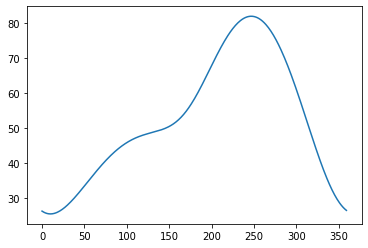

In [7]:
point = 1

min_row = 360 * (point - 1)
max_row = 360 * point

mew_first = mew_field[min_row:max_row]
plt.plot(mew_first.stress.to_numpy())
# plt.plot(mew_first.time, mew_first.principal2)
# plt.title('MEW Plot')

# plt.figure()

# plt.title('SIMON Plot')
simon_first = simon_field[min_row:max_row]


print(mew_first.stress.argmin())
print(simon_first.stress.argmin())

print(mew_first.stress.argmax())
print(simon_first.stress.argmax())

min_distance = mew_first.stress.argmin() - simon_first.stress.argmin()
max_distance = mew_first.stress.argmax() - simon_first.stress.argmax()

shift = int(np.round(np.average([min_distance, max_distance]), 0))
# plt.plot(np.roll(simon_first.stress, shift))
shift

# find_phase_shift(mew_first.stress, simon_first.stress)
# plt.plot(np.roll(simon_first.stress, 0))

(array([247]),)
(array([127, 246]),)
(array([10]),)
(array([  5, 161]),)


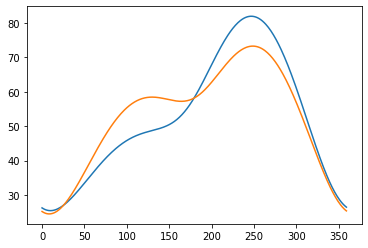

In [8]:
m = mew_first.stress.to_numpy()
s = simon_first.stress.to_numpy()

# print(find_peaks_cwt(s, np.arange(1, 360)))
# print(find_peaks_cwt(m, np.arange(1, 360)))

# plt.plot(m[175:185])
# plt.plot(s[175:185])

print(argrelextrema(m, np.greater))
print(argrelextrema(s, np.greater))

print(argrelextrema(m, np.less))
print(argrelextrema(s, np.less))


m1 = argrelextrema(m, np.greater)[0]
s1 = argrelextrema(s, np.greater)[0]

m2 = argrelextrema(m, np.less)[0]
s2 = argrelextrema(s, np.less)[0]

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def match_extrema(a, b):
    if len(a) == len(b):
        return a, b
    elif len(a) > len(b):
        a_new = []
        for index in b:
            nearest_index = find_nearest(a, index)
            a_new.append(nearest_index)
        
        return np.array(a_new), b
    else: # len(b) > len(a):
        b_new = []
        for index in a:
            nearest_index = find_nearest(b, index)
            b_new.append(nearest_index)
        
        return a, np.array(b_new)

def average_shift(a, b):
    return np.average(a - b)
    
def find_phase_shift(a, b):
    a_maxima = scipy.signal.argrelextrema(a, np.greater)[0]
    a_minima = scipy.signal.argrelextrema(a, np.less)[0]
    b_maxima = scipy.signal.argrelextrema(b, np.greater)[0]
    b_minima = scipy.signal.argrelextrema(b, np.less)[0]
    
    a_maxima, b_maxima = match_extrema(a_maxima, b_maxima)
    a_minima, b_minima = match_extrema(a_minima, b_minima)
    
    maxima_shift = np.average(a_maxima - b_maxima)
    minima_shift = np.average(a_minima - b_minima)
    
    return int(np.round(np.average([maxima_shift, minima_shift]), 0))

shift = find_phase_shift(m, s)
shifted = np.roll(s, shift)
plt.plot(m)
plt.plot(shifted)

# TODO:

### Run comparison on each different cycloid

### Quantify Difference between MEW and SIMON in some way
  - How do we handle differences in phase shift (x axis shift)?
  - We want to consider an overall shape matching as good
  
Looks like `np.corrcoef` can provide a good similarity value while taking phase shifting into consideration. Values in the matrix outside of the diagonal will provide the similarity value (0.0 - 1.0).

`scipy.signal.correlate` provides an entire cross-correlation when both stress fields are regularized by substracting the mean and dividing by the standard deviation. With that we can find the number of time steps that the two methods are out of phase.


In [11]:
def regularize(series):
    result = np.array(series - series.mean())
    result /= series.std()
    
    return result


# def find_phase_shift(a, b):
#     min_distance = a.argmin() - b.argmin()
#     max_distance = a.argmax() - b.argmax()
    
#     avg_distance = int(np.round(np.average([min_distance, max_distance]), 0))
#     return avg_distance


def check_similarity(cycloid_point):
    simon_points = cycloid_point.copy()
    mew_points = cycloid_point.copy()

    mew_points['lon'] = np.radians(360 - mew_points['lon'])
    mew_points['lat'] = np.radians(90 - mew_points['lat'])
    mew_field = tools.build_mew_stress_field(sat, europa_orbit_seconds, mew_points)
    
    # make sure mew field is sorted the same as the simon field will be
    mew_field['lat'] = 90 - np.degrees(mew_field.lat)
    mew_field['lon'] = 360 - np.degrees(mew_field.lon)
    mew_field['stress'] = mew_field.principal1 / 1000 # Pa to kPa
    mew_field = mew_field.sort_values(['lat', 'lon', 'time'])
    
    simon_field = tools.build_simon_stress_field(interior, simon_points, 0, 0.01, np.radians(0.1), 0)
    
    shift = find_phase_shift(mew_field.stress.to_numpy(), simon_field.stress.to_numpy())
    
    shifted = np.roll(simon_field.stress, shift)
    rmse = np.sqrt(mean_squared_error(mew_field.stress.to_numpy(), shifted))
    
    return dict(shift=shift, mew_max=max(mew_field.stress),
               mew_min=min(mew_field.stress), simon_max=max(simon_field.stress),
               simon_min=min(simon_field.stress), rmse=rmse)

In [12]:
results = []

for cycloid in cycloids:
    print('Processing:', cycloid)
    point = cycloids[cycloid].curve.head(1)
    result = check_similarity(point)
    result['cycloid'] = cycloid
    results.append(result)
    
similarity_frame = pd.DataFrame(results)
display(similarity_frame)

Processing: alex
Processing: carly
Processing: cilicia
Processing: delphi
Processing: dirk
Processing: mira
Processing: odessa
Processing: sidon
Processing: tyrrel
Processing: yaphet


,shift,mew_max,mew_min,simon_max,simon_min,rmse,cycloid
0,-5,77.149503,-59.021626,75.396939,-58.558192,1.271086,alex
1,0,87.166583,-63.649322,91.740447,-68.573028,3.773936,carly
2,2,82.432346,25.219692,73.295229,24.506098,6.385830,cilicia
3,2,89.233322,18.573146,85.338739,16.949147,3.432594,delphi
4,0,97.720075,-67.161392,98.935079,-67.853406,1.672243,dirk
5,10,55.436452,-7.514695,63.989232,-10.472471,5.792290,mira
6,7,63.169281,-17.018274,71.851968,-22.368530,6.193932,odessa
7,2,89.235653,18.548216,85.365177,16.918989,3.415838,sidon
8,0,96.744196,-67.479610,98.486559,-68.993371,1.737306,tyrrel
9,2,72.869384,-68.385699,73.830856,-70.012054,1.340535,yaphet


372
[329.32723148]
13
342.4392246523415


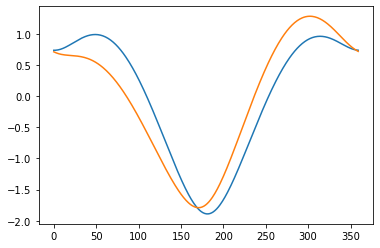

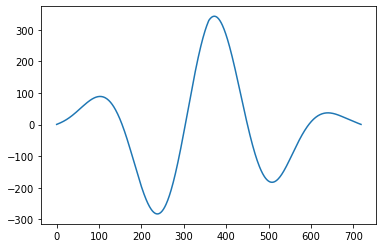

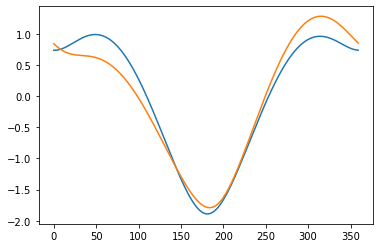

In [79]:
# mew_stress = [stress / max(mew_first.principal1) for stress in mew_first.principal1]
# simon_stress = [stress / max(simon_first.stress) for stress in simon_first.stress]

mew_stress = np.array(mew_first.principal1 / 1000.)
mew_stress -= mew_stress.mean()
mew_stress /= mew_stress.std()

simon_stress = simon_first.stress - simon_first.stress.mean()
simon_stress /= simon_stress.std()

# plt.plot(simon_stress)
plt.plot(mew_stress)
# simon_stress = np.roll(simon_stress, 100)
plt.plot(simon_stress)
plt.figure()

result = correlate(mew_stress, simon_stress, method='fft')

plt.plot(result)

num_samples = len(mew_stress)
dt = np.arange(1-num_samples, num_samples)

recovered_time_shift = dt[result.argmax()]

print(result.argmax())
print(recovered_time_shift)
print(result[result.argmax()])

plt.figure()

simon_stress = np.roll(simon_stress, recovered_time_shift)
plt.plot(mew_stress)
plt.plot(simon_stress)

In [ ]:
similarity = np.corrcoef(mew_stress, simon_stress)[1, 0]
similarity

In [ ]:
result = correlate(mew_stress, mew_stress)
plt.plot(result)

In [30]:
np.correlate(mew_stress, simon_stress)

array([161.99365089])

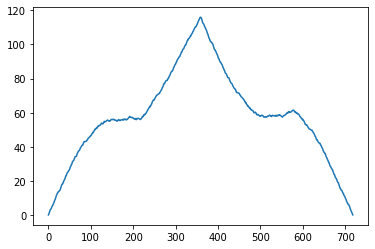

In [32]:
junk = np.random.rand(len(mew_stress))
result = correlate(mew_stress, junk)
plt.plot(result)

In [33]:
np.correlate(mew_stress, junk)

array([115.91884865])

In [35]:
np.cov(mew_stress, mew_stress)

array([[0.15773227, 0.15773227],
       [0.15773227, 0.15773227]])